# PN2V Prediction
Please run the `2_ProbabilisticNoise2VoidTraining.ipynb` notebook first.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread


from ppn2v.pn2v.utils import PSNR
from ppn2v.pn2v import utils
from ppn2v.pn2v import prediction
from ppn2v.pn2v import histNoiseModel
from ppn2v.pn2v import gaussianMixtureNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='../../../data/Mouse actin/Mouse actin/'

# Load the test data
dataTest=imread(path+"sample_attempt2.tif")[:,:,:512] 
# We are loading only a sub image to speed up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]



### Load the Network and Noise Model

In [3]:
dataName = 'mouseactin'# Use the same name as used in 2_ProbabilisticNoise2VoidTraining.ipynb. This is a part of model name created in ProbabilisticNoise2VoidTraining.ipynb
# Load the noiseModel of interest 
nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'calibration'
# nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
# nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
# nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
net=torch.load(path+"/last_"+namePN2VModel+".net")
if('HistNoiseModel' in namePN2VModel):
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
elif('GMMNoiseModel' in namePN2VModel):
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params = params, device = device)    

### Evaluation

image: 0
PSNR input 23.643400849264026
PSNR prior 33.52699232426379
PSNR mse 33.89670820182789
-----------------------------------
image: 1
PSNR input 23.620883803207068
PSNR prior 33.520672866076076
PSNR mse 33.885822003318694
-----------------------------------
image: 2
PSNR input 23.667113469021835
PSNR prior 33.57733161776855
PSNR mse 33.94830170345793
-----------------------------------
image: 3
PSNR input 23.64709110714436
PSNR prior 33.514320541686295
PSNR mse 33.8777730887041
-----------------------------------
image: 4
PSNR input 23.672914919463746
PSNR prior 33.46493185768756
PSNR mse 33.82673066831806
-----------------------------------
image: 5
PSNR input 23.669950605295924
PSNR prior 33.45103385378164
PSNR mse 33.81052775534073
-----------------------------------
image: 6
PSNR input 23.70231487515842
PSNR prior 33.56247115031563
PSNR mse 33.940371896301755
-----------------------------------
image: 7
PSNR input 23.705049534851174
PSNR prior 33.511215870888414
PSNR mse 33.8

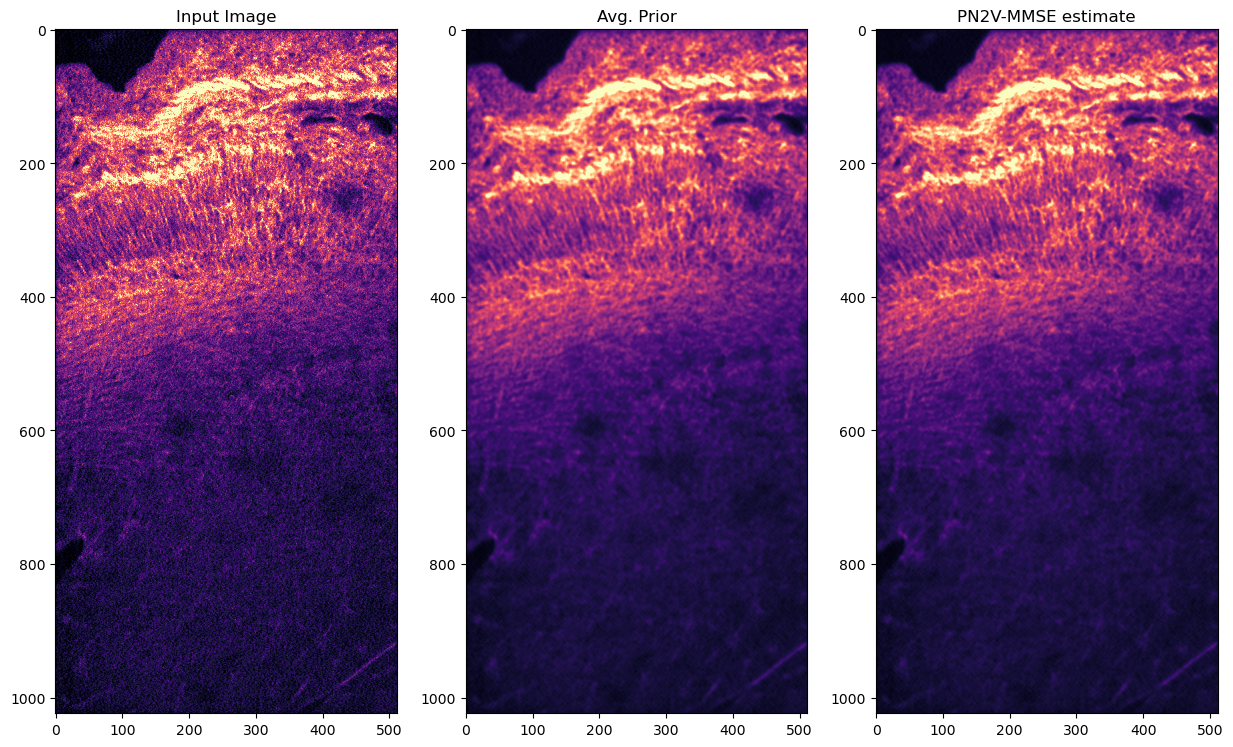

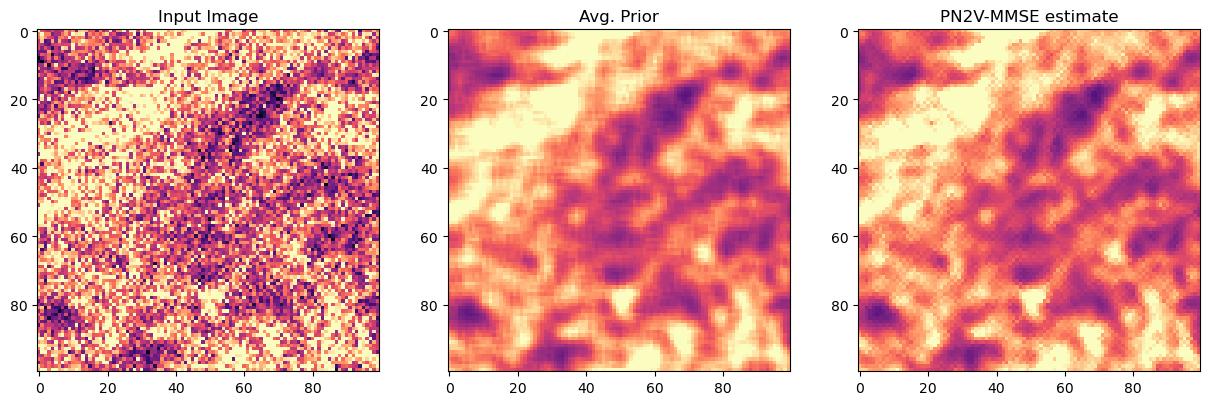

Avg PSNR Prior: 33.44364180855253 +-(2SEM) 0.021570278958349003
Avg PSNR MMSE: 33.810010424838666 +-(2SEM) 0.022453386542263733


In [6]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means, mseEst = prediction.tiledPredict(im, net, ps=128, overlap=48,
                                             device=device, noiseModel=noiseModel)

    
    resultImgs.append(mseEst)
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    psnr=PSNR(gt, mseEst,rangePSNR )
    psnrPrior=PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst, vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/PN2VBootGMM.png', mseEst)
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/PN2VBootGMMSmall.png', mseEst[100:200,150:250])
plt.show()

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )